# Integer minimum cost flows with separable convex cost objective

The Problem of finding the most likely mulitpath split for a payment pair on the lightning network can be reduced to an **integer minimum cost flows with separable convex cost objective** and yields a polynomial solver c.f.: https://twitter.com/renepickhardt/status/1385144337907044352

This notebook tries to implement a solution given in the Textbook Network Flows Network Flows: Theory, Algorithms, and Applications by Ravindra K. Ahuja, Thomas L. Magnanti and James B. Orlin

This approach follows mainly chapter 9, 10.2 and 14.5 of the Textbook. 

Other good resources are the Lecture series http://courses.csail.mit.edu/6.854/20/ by David Karger (http://people.csail.mit.edu/karger/) with lecture notes at http://courses.csail.mit.edu/6.854/current/Notes/ and more specificially http://courses.csail.mit.edu/6.854/current/Notes/n09-mincostflow.html and the relevant subset of the recorded videos at this playlist: https://www.youtube.com/playlist?list=PLaRKlIqjjguDXlnJWG2T7U52iHZl8Edrcv

Other good resources are the lecture nodes by Hochbaum: https://hochbaum.ieor.berkeley.edu/

I did not find an open source implementation. Code for similar problems seems to be part of this library: https://github.com/frangio68/Min-Cost-Flow-Class but it seems to only allow quadratic cost functions. 

Following previous research ( https://arxiv.org/abs/2103.08576 ) our cost function is f(x) = log(c) - log(c-x) which turns out to be convex (f'(x) = 1/(c-x) and f"(x) = 1/(c-x)^2 from which we can see that f"(x) > 0)

## Donate to this project and work

If you look at the result a probability of 65% to deliver 11 onions with a total sum of 92mBTC is crazy in comparision to how many attempts we currently need. This is what I call an unfair competitive advantage. While I could have created a company and sell the technology to exchanges and payment providers I have decided to open source it because I think knowledge should be open. So if you think this increases the value of the Lightning Network or Bitcoin and if this proved to be useful for you please consider a donation to `bc1qw8220g7wwv7y0kr0chfmgp9shkkqz7kutlnzyf` if you want me to have more time to tinker about issues you could also opt to become a monthly patreon to support my work at: https://www.patreon.com/renepickhardt

For a bit more context of why your donation makes a difference look here: https://twitter.com/renepickhardt/status/1398248328798801921

In [1]:
import json
import networkx as nx
import math

log = math.log2

## some helpers for graphs

introduce some helper functions for handling graphs and importing out data structure / example

In [55]:
def cost(a,c):
    """returns the negative log probability for the success to deliver `a` satoshis through a channel of capacity `c`"""
    return log(c+1)-log(c+1-a)    

def import_channel_graph():
    """
    parses the channel_graph from the c-lightning API. one coule just create a different function here to parse
    data from other implementations
    """
    # retrieve this by: lightning-cli listchannels > listchannels.json
    f = open("listchannels.json")
    jsn = json.load(f)
    G = nx.DiGraph()
    for channel in jsn["channels"]:
        src = channel["source"]
        dest = channel["destination"]
        #we divide capacities by 10000 to for quicker computation. 
        #This means that we will only approximate the optimal solution 
        cap = int(int(channel["satoshis"])/10000)
        sid = channel["short_channel_id"]
        #FIXME: this will ignore multiedges on the lightning network and assume just a graph without parallel channels
        #for our proof of concept this is ok However the augment_path function currently assumes that the residual
        # network has at most two edges in one direction per node pair which means that no multi edges are supported
        # fixing this is an engineering challange of handeling data and not a problem for the algorithm
        # Thus for better understandability we made the assumption of a graph without parallel channels at this point.
        
        if G.has_edge(src,dest)==False and G.has_edge(dest,src)==False:
            G.add_edge(src,dest,cap=cap,sid=sid,cost=cost)
            G.add_edge(dest,src,cap=cap,sid=sid,cost=cost)
        
        
    return G

def add_fees(G):
    f = open("listchannels.json")
    jsn = json.load(f)
    for channel in jsn["channels"]:
        src = channel["source"]
        dest = channel["destination"]
        b = int(channel["base_fee_millisatoshi"])
        r = int(channel["fee_per_millionth"])
        if G.has_edge(src,dest):
            G[src][dest]["r"]=r
            G[src][dest]["b"]=b
            
def next_hop(path):
    for i in range(1,len(path)):
        src = path[i-1]
        dest = path[i]
        yield (src,dest)
        
def path_str(path):
    it = path[0]
    if len(it)>5:
        it = it[:5]
    res = it
    for src, dest in next_hop(path):
        if len(dest)>5:
            dest = dest[:5]
        res += " {}".format(dest)
    return res

def print_residual(r,G,x):
    for i,j in G.edges():
        cap = G[i][j]["cap"]
        f = x[i][j]
        if r.has_edge(i,j):
            print(i,j,r[i][j])
        if r.has_edge(j,i):
            print(j,i,r[j][i])   

            


In [56]:
def generate_null_flow(G):
    flow = {n:{} for n in G.nodes()}
    for u,v in G.edges():
        flow[u][v]=0
        flow[v][u]=0
    return flow



## The actual implementation of the min cost flow solver for a convex cost function

it consists of 4 helper functions: 

* `compute_delta_residual_network(G,x,delta,pi,C=cost):`
* `fulfill_reduced_cost_optimiality_rule(R,x,e,delta):`
* `augment_path(flow,path,amt,R):`
* `recompute_reduced_cost(R,pi):`

which are used in the actuall api call `capacity_scaling_min_cost_flow(s,d,U,G):`


In [64]:
def compute_delta_residual_network(G,x,delta,pi):#,C=cost):
    """
    The delta residual network is returned as a multigraph. 
    
    Note that the delta residual network can be seen as a uni-capacity network. 
    This means that if an edge is in the residual network we can flow delta in the actual network
    and otherwise we can't. 
    As the delta residual network only cares about reduced cost the fuction also gets the potentials passed

    For convenience a bit more information is stored as attributes on the edges:
    uc = unit cost to deliver 1 unit in the delta phase
    rc = reduced cost after aplying potentials
    original_capacity = the capacity of the edge in the original network
    """
    
    residual = nx.MultiDiGraph()
    for i, j in G.edges():
        cap = G[i][j]["cap"]
        f = x[i][j]
        C = G[i][j]["cost"]
        if f+delta <=cap:
            unit_cost = (C(f + delta, cap) - C(f,cap))/delta
            residual.add_edge(i,j,uc= unit_cost,rc = unit_cost - pi[i] + pi[j],original_cap=cap)#,key=0,k=0)
        if delta <= f:#backward flow is possible
            unit_cost = (C(f - delta, cap) - C(f,cap))/(delta)
            residual.add_edge(j,i,uc= unit_cost,rc=unit_cost - pi[j] + pi[i],original_cap=cap)#,key=1,k=1)
        
    return residual

In [65]:
def fulfill_reduced_cost_optimiality_rule(R,x,e,delta):
    """
    saturates edges non optimal edges in the delta residual network
    
    This is achieved by by:
     - adding or removing delta to the flow `x` of the non optimal edge
     - saturating the flow value of the edge in the delta-residual network `R`
     - changing excesses (suply and demand) of the respeciting nodes to conserve the original flow
    """
    to_remove=set()
    for i,j,k in R.edges(keys=True):
        if R[i][j][k]["rc"] < 0:

            cap = R[i][j][k]["original_cap"]

            # we can remove flow from the edge as the backward flow was larger than delta
            if x[j][i]>=delta:
                x[j][i]-=delta
                to_remove.add((i,j,k))

            # The following two conditions are probably never met unless we allow negative cost 
            # we can add flow in the forward direction as the original capacity is not saturated yet
            elif x[i][j]+delta <= cap:
                x[i][j]+=delta
                to_remove.add((i,j,k))
            else:
                raise Exception("Negative reduced cost detected but not fixable given delta: {} cap: {} and f: {}".format(delta,R[i][j][k]["original_cap"],min(x[i][j],x[j][i])))

            #adopting the excess values
            e[i]-=delta
            e[j]+=delta

    for i,j,k in to_remove:
        data={key:val for key,val in R[i][j][k].items()}
        data["rc"]=-R[i][j][k]["rc"]
        data["uc"]=-R[i][j][k]["uc"]
        
        # k can be used as key via: https://networkx.org/documentation/stable/reference/classes/generated/networkx.MultiGraph.remove_edge.html
        R.remove_edge(i,j,key=k)
        #this saturates the edge which was previously not fullfilling the reduced cost optimality criterium
        #TODO: Test that this is the edge with lower reduced cost / test other one is always 0?
        #TODO: am I always allowed to add a reverse edge?
        R.add_edge(j,i,**data)

In [66]:
def augment_path(flow,path,amt,R):
    """ augments a given flow with an additional amount amt along some path P
    
    the residual network is necessary as we also need to saturate or 
    """
    for src,dest in next_hop(path):
        if flow[dest][src]>0:
            flow[dest][src]-=amt
        else:
            flow[src][dest]+=amt

        min_k=-1
        min_rc=max(data["rc"] for _,data in R[src][dest].items())+1
        for k,data in R[src][dest].items():
            if data["rc"]<min_rc:
                min_k=k
                min_rc=data["rc"]
        
        data = R[src][dest][min_k]
        data["rc"]=-R[src][dest][min_k]["rc"]
        data["uc"]=-R[src][dest][min_k]["uc"]
        R.remove_edge(src,dest,key=min_k)
        #this saturates the edge which was previously not fullfilling the reduced cost optimality criterium
        #TODO: Test that this is the edge with lower reduced cost / test other one is always 0?
        #TODO: am I always allowed to add a reverse edge?
        R.add_edge(dest,src,**data)

In [67]:
def recompute_reduced_cost(R,pi):
    """
    helper function to update the reduced costs after potentials have changed
    
    will be called after augmenting every path
    """
    
    for i,j in R.edges():
        for k,data in R[i][j].items():
            R[i][j][k]["rc"]=data["uc"]-pi[i]+pi[j]

In [68]:
def capacity_scaling_min_cost_flow(s,d,U,G):
    """ 
    returns the min cost flow computed via the capacity scaling algorithm for a convex cost functions
    
    s: is the source node
    d: is the destination or sink
    U: is the amount of flow to be sent
    G: is the graph of which s and d must be elements of    
    """
    
    #set up the flow data structure
    x = generate_null_flow(G)
    
    #initialize excess data structure in particular set supply and demand of source and sink nodes
    e = {n:0 for n in G.nodes}
    e[s]=U
    e[d]=-U
    delta = 2**int(log(U))
    total_cnt=0
    while delta >= 1:
        #print("{}-scaling phase".format(delta))

        #TODO: it seems indeed as if we need to reset potentials in every delta scaling phase
        pi = {n:0 for n in G.nodes}
        R = compute_delta_residual_network(G,x,delta,pi)

        #We saturate edges in the residual network if the reduced cost optimalitiy test fails and modify the flow and excess values
        fulfill_reduced_cost_optimiality_rule(R,x,e,delta)
        
        #compute the set of source and sink nodes for augmenting paths
        S = [n for n,k in e.items() if k>=delta]
        T = [n for n,k in e.items() if k<=-delta]
        
        # TODO: test if I can replace the entire while loop with nx.min_cost_flow on residual graph
        
        #start augmenting paths this is the expensive part of the algorithm
        cnt = 0
        while len(S) >0 and len(T)>0:
            #print("|S(delta)|={} |T(delta)|={}".format(len(S),len(T)))
            
            #select and arbitrary source and sink node for augmenting paths. 
            #since it is arbitrary we can just take the last element in each set 
            k=S[-1]
            l=T[-1]
            
            #compute shortest paths on the reduced cost in the unsaturated delta residual network
            distances, paths = nx.single_source_dijkstra(R,k,weight="rc")
            
            #the following is needed in case the residual network is not connected 
            #for the algorithm we just need any shortes path so we can find one in our connected component
            idx =-1
            while l not in paths:
                idx -=1
                l=T[idx]
            path = paths[l]
                
            # on the selected path for augmentation change the potentials of all nodes acording to the shortest distance 
            # from the source of the augmented path. This will maintain the optimality of reduced cost in future rounds 
            for n, d_value in distances.items():
                pi[n]-=d_value
            
            #TODO: make sure order of the following two calls does in deed not matter
            #with a better data structure this could happen very wellwith in one function call instead of two
            recompute_reduced_cost(R,pi)
            augment_path(x,path,delta,R)
            
            #print("augmented path:", path_str(path), "with:", delta)
            e[k]-=delta
            e[l]+=delta
            
            # technically we would not have to recompute S and T but we could just remove the items if the exess and demant are fullfiled
            S = [n for n,k in e.items() if k>=delta]
            T = [n for n,k in e.items() if k<=-delta]
            cnt+=1
        total_cnt+=cnt
        print("augmented {} paths in the {}-scaling phase and {} paths in total".format(cnt,delta,total_cnt))
        delta = int(delta/2)
    return x

## Some examples calls
the first of the example graph and the second one on the lightning network

In [70]:
E = nx.DiGraph()
E.add_edge("S","A",cap=2, cost=cost)
E.add_edge("A","S",cap=2, cost=cost)
E.add_edge("S","X",cap=1, cost=cost)
E.add_edge("X","S",cap=1, cost=cost)
E.add_edge("A","B",cap=2, cost=cost)
E.add_edge("B","A",cap=2, cost=cost)
E.add_edge("X","B",cap=9, cost=cost)
E.add_edge("B","X",cap=9, cost=cost)
E.add_edge("X","Y",cap=7, cost=cost)
E.add_edge("Y","X",cap=7, cost=cost)
E.add_edge("Y","D",cap=4, cost=cost)
E.add_edge("D","Y",cap=4, cost=cost)
E.add_edge("B","D",cap=4, cost=cost)
E.add_edge("D","B",cap=4, cost=cost)

x = capacity_scaling_min_cost_flow("S","D",2,E)
print(x)

augmented 1 paths in the 2-scaling phase and 1 paths in total
augmented 1 paths in the 1-scaling phase and 2 paths in total
{'S': {'A': 1, 'X': 1}, 'A': {'S': 0, 'B': 1}, 'X': {'S': 0, 'B': 0, 'Y': 1}, 'B': {'A': 0, 'X': 0, 'D': 1}, 'Y': {'X': 0, 'D': 1}, 'D': {'B': 0, 'Y': 0}}


In [71]:
channel_graph = import_channel_graph()
add_fees(channel_graph)
SRC = "03efccf2c383d7bf340da9a3f02e2c23104a0e4fe8ac1a880c8e2dc92fbdacd9df"
DEST = "022c699df736064b51a33017abfc4d577d133f7124ac117d3d9f9633b6297a3b6a"
FLOW = 920

from timeit import default_timer as timer

start = timer()
x = capacity_scaling_min_cost_flow(SRC,DEST,FLOW, channel_graph)
end = timer()
print("comutation took {} seconds".format(end - start)) 


augmented 1 paths in the 512-scaling phase and 1 paths in total
augmented 2 paths in the 256-scaling phase and 3 paths in total
augmented 4 paths in the 128-scaling phase and 7 paths in total
augmented 5 paths in the 64-scaling phase and 12 paths in total
augmented 8 paths in the 32-scaling phase and 20 paths in total
augmented 11 paths in the 16-scaling phase and 31 paths in total
augmented 11 paths in the 8-scaling phase and 42 paths in total
augmented 11 paths in the 4-scaling phase and 53 paths in total
augmented 11 paths in the 2-scaling phase and 64 paths in total
augmented 11 paths in the 1-scaling phase and 75 paths in total
comutation took 23.748095542017836 seconds


## Test if the result is indeed a min cost flow!
we have a minimum cost flow if the 1Residual net has no negative cycles!

In [119]:
def compute_cost(G,x):
    total_cost = 0
    for s,d in G.edges():
        c = G[s][d]["cap"]
        f = x[s][d]
        if f > 0:
            total_cost+=G[s][d]["cost"](f,c)
            
    return total_cost

In [112]:
pi = {n:0 for n in channel_graph.nodes}
R = compute_delta_residual_network(channel_graph,x,1,pi)
if nx.negative_edge_cycle(channel_graph,weight="rc"):
    print("min cost flow not optimal")
else:
    print("min cost flow was optimal")

print("min cost flow has probability: ",2**-compute_cost(channel_graph,x) )

min cost flow was optimal


UnboundLocalError: local variable 's' referenced before assignment

## Some evaluation and nicer depiction of the results

In [13]:
nodes = set()
for src, v in x.items():
    for dest, f in v.items():
        if f>0:
            nodes.add(src)
            nodes.add(dest)

print("Min cost flow of {} from {} to {} includes {} nodes: ".format(FLOW,SRC[:5],DEST[:5],len(nodes)))

print("\nOutflow of source node: ")
total_flow = 0
outprob = 1
for dest,f in x[SRC].items():
    if f>0:
        #cap = 0
        #if channel_graph.has_edge(SRC,dest):
        cap = channel_graph[SRC][dest]["cap"]
        #else: 
        #    channel_graph[DEST][dest]["cap"]
        print(SRC[:5],dest[:5], "flow {} of cap {}: ({:4.2f})".format(f,cap,(cap+1-f)/(cap+1)) )
        total_flow+=f
        outprob*=(cap+1-f)/(cap+1)
print("resulting in total outflow of:", total_flow, "prob: ", outprob)

print("\nInflow at destination node: ")
total_flow = 0
inprob=1
for src, v in x.items():
    for dest, f in v.items():
        if f>0 and dest == DEST:
            cap = channel_graph[src][dest]["cap"]
            print(src[:5],dest[:5], "flow {} of cap {}: ({:4.2f})".format(f,cap,(cap+1-f)/(cap+1)) )
            total_flow+=f
            inprob*=(cap+1-f)/(cap+1)
print("resulting in a total inflow at the destination of: ", total_flow, "prob:", inprob)

print("\nEntire flow: ")
res = 1
for src, v in x.items():
    for dest, f in v.items():
        if f>0:
            nodes.add(src)
            nodes.add(dest)
            cap = channel_graph[src][dest]["cap"]
            print(src[:5], dest[:5],f,"of", cap, "({:4.2f})".format((cap+1-f)/(cap+1)) )
            res*=(cap+1-f)/(cap+1)
            
print("total probability: ", res)
print("with knowledge of local balance at source and destination: ", res/inprob/outprob)

Min cost flow of 920 from 03efc to 022c6 includes 17 nodes: 

Outflow of source node: 
03efc 02247 flow 330 of cap 1677: (0.80)
03efc 03267 flow 336 of cap 900: (0.63)
03efc 03cde flow 254 of cap 1000: (0.75)
resulting in total outflow of: 920 prob:  0.3759309800273424

Inflow at destination node: 
03e28 022c6 flow 379 of cap 1677: (0.77)
0390b 022c6 flow 40 of cap 1677: (0.98)
03d37 022c6 flow 41 of cap 1677: (0.98)
03267 022c6 flow 336 of cap 1677: (0.80)
024d2 022c6 flow 41 of cap 900: (0.95)
031ce 022c6 flow 41 of cap 1677: (0.98)
022c2 022c6 flow 41 of cap 1677: (0.98)
02d4b 022c6 flow 1 of cap 1677: (1.00)
resulting in a total inflow at the destination of:  920 prob: 0.5352844532850801

Entire flow: 
03e28 022c6 379 of 1677 (0.77)
03864 021c9 287 of 30000 (0.99)
03efc 02247 330 of 1677 (0.80)
03efc 03267 336 of 900 (0.63)
03efc 03cde 254 of 1000 (0.75)
02e90 03864 34 of 11000 (1.00)
0390b 022c6 40 of 1677 (0.98)
03d37 022c6 41 of 1677 (0.98)
03267 022c6 336 of 1677 (0.80)
024d2 0

In [201]:
def disect_flow_to_paths(x,s,d):
    G = nx.DiGraph()
    for src, v in x.items():
        for dest, f in v.items():
            if f>0:
                G.add_edge(src,dest,weight=f)
    m = 1
    paths = []
    while m>0:
        try: 
            path = nx.shortest_path(G,s,d)
            m = min(G[src][dest]["weight"] for src, dest in next_hop(path))
            #t+=m
            #print("{} sats along {}".format(m*10000,path_str(path)))
            paths.append((path,m))
            for src,dest in next_hop(path):
                G[src][dest]["weight"]-=m
                if G[src][dest]["weight"]==0:
                    G.remove_edge(src,dest)
        except: 
            break
    return paths
    
paths = disect_flow_to_paths(x,SRC,DEST)
fees = 0
for path,amt in paths:
    for src,dest in next_hop(path):
        #print(amt, channel_graph[src][dest]["b"], int(channel_graph[src][dest]["r"]*amt/100))
        fees += channel_graph[src][dest]["b"] + int(channel_graph[src][dest]["r"]*amt/100)
print("with an expected total fee of {} satoshi".format(fees/1000))

with an expected total fee of 14.815 satoshi


## Simulation in a realistic setting

In [128]:
import random

In [193]:
def initialize_balances(G):
    for s,d in G.edges():
        cap = G[s][d]["cap"]
        bal=int(random.random()*cap)
        G[s][d]["balance"]=bal
        G[d][s]["balance"]=cap - bal

initialize_balances(channel_graph)

In [194]:
def test_onion(amt, path, G):
    for src,dest in next_hop(path):
        if G[src][dest]["balance"]<amt:
            return False
    return True

def update_success_onion(amt,path,G):
    for src,dest in next_hop(path):
        G[src][dest]["cap"]-=amt
        G[src][dest]["balance"]-=amt

def update_failure_onion(amt,path,G):
    for src,dest in next_hop(path):
        if G[src][dest]["balance"]>=amt:
            if amt > G[src][dest]["min_possible"]:
                G[src][dest]["min_possible"]=amt
        else:
            G[src][dest]["cap"]=amt
            break
            


In [202]:

def pay(U, s, d, G):
    H = G.copy()
    for src,dest in H.edges():
        H[src][dest]["min_possible"] = 0
    zerocost = lambda a,c : 0
    for n in H[s]:
        H[s][n]["cap"]=H[s][n]["balance"]
        H[s][n]["cost"]=zerocost
        H[n][s]["cap"]=H[n][s]["balance"]
        H[n][s]["cost"]=zerocost
    
    """for n,_ in H.in_edges(d):
        H[d][n]["cap"]=H[d][n]["balance"]
        H[d][n]["cost"]=zerocost
        H[n][d]["cap"]=H[n][d]["balance"]
        H[n][d]["cost"]=zerocost
    """
    delivered = 0 
    fees = 0
    while delivered !=U:
        x = capacity_scaling_min_cost_flow(s,d,U-delivered, H)
        print("min cost flow to deliver {} has probability: {}".format(U-delivered,2**-compute_cost(H,x)))
        
        paths = disect_flow_to_paths(x,s,d)
        for path,amt in paths:
            path_fees = 0
            print("{} sats along {}".format(amt*10000,path_str(path)),end=" ")
            if test_onion(amt,path,H)==True:
                print("succeeds")
                update_success_onion(amt,path,H)
                delivered+=amt
                for src,dest in next_hop(path):
                    fees += channel_graph[src][dest]["b"] + int(channel_graph[src][dest]["r"]*amt/100)
            else:
                print("fails")
                update_failure_onion(amt,path,H)
    
    print("with an expected total fee of {} satoshi".format(fees/1000))
        
    return x

In [203]:
x = pay(1023, SRC,DEST, channel_graph)
#H = pay(920, SRC,DEST, channel_graph)


augmented 1 paths in the 512-scaling phase and 1 paths in total
augmented 2 paths in the 256-scaling phase and 3 paths in total
augmented 2 paths in the 128-scaling phase and 5 paths in total
augmented 3 paths in the 64-scaling phase and 8 paths in total
augmented 3 paths in the 32-scaling phase and 11 paths in total
augmented 3 paths in the 16-scaling phase and 14 paths in total
augmented 4 paths in the 8-scaling phase and 18 paths in total
augmented 4 paths in the 4-scaling phase and 22 paths in total
augmented 4 paths in the 2-scaling phase and 26 paths in total
augmented 4 paths in the 1-scaling phase and 30 paths in total
min cost flow to deliver 1023 has probability: 0.4170766444082663
7680000 sats along 03efc 03267 022c6 fails
290000 sats along 03efc 02b68 03e28 022c6 succeeds
2260000 sats along 03efc 03cde 03864 021c9 03d06 03e28 022c6 succeeds
augmented 1 paths in the 512-scaling phase and 1 paths in total
augmented 2 paths in the 256-scaling phase and 3 paths in total
augment

In [139]:
print(sum(channel_graph[SRC][x]["balance"] for x in channel_graph[SRC]))
print(sum(channel_graph[x][DEST]["balance"] for x,_ in channel_graph.in_edges(DEST)))


4485
14842


# WIP code snippets not cleaned up yet

ImportError: requires pygraphviz http://pygraphviz.github.io/

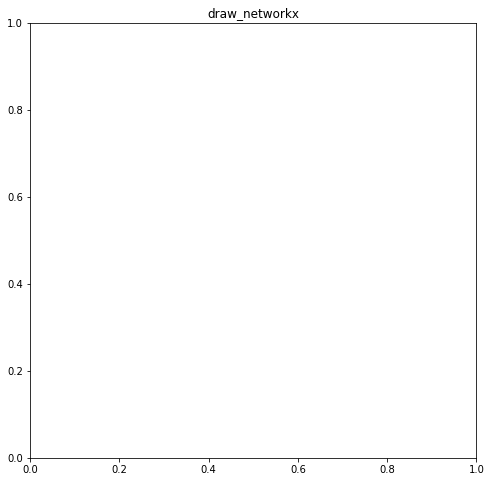

In [261]:
from matplotlib import pyplot as plt
from networkx.drawing.nx_agraph import graphviz_layout
#import matplotlib.pyplot as plt
G = nx.DiGraph()
for src, v in x.items():
    for dest, f in v.items():
        if f > 0:
            G.add_edge(src,dest,flow=f)

#for v in G.nodes():
#    G[v]['name']=v[:4]


#all nodes must have subset_key (default='subset') as data (can probably be used as distance in bfs)
#pos = nx.multipartite_layout(G)
fig = plt.figure(figsize=(8,8))

#write_dot(G,'test.dot')

# same layout using matplotlib with no labels
plt.title('draw_networkx')
pos =graphviz_layout(G, prog='dot')
nx.draw(G, pos, with_labels=False, arrows=True)

pos = nx.spectral_layout(G)
nx.draw(G, pos=pos) 
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
#plt.savefig('this.png')
plt.show()
"""
#nx.draw(G, pos)
node_labels = nx.get_node_attributes(G,'name')
nx.draw_networkx_labels(G, pos, labels = node_labels)
edge_labels = nx.get_edge_attributes(G,'flow')
nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels)
#plt.savefig('this.png')
plt.show()"""

In [206]:

x = generate_null_flow(G)
pi = {n:0 for n in G.nodes}
R = compute_delta_residual_network(G,x,2,pi)
print_residual(R,G,x)

x["S"]["A"]=2
x["A"]["B"]=2
x["B"]["D"]=2

"""
pi["S"]-=0
pi["A"]-=R["S"]["A"][0]["rc"]
pi["B"]-=R["S"]["A"][0]["rc"]+R["A"]["B"][0]["rc"]
pi["X"]-=R["S"]["A"][0]["rc"]+R["A"]["B"][0]["rc"] + R["B"]["X"][0]["rc"]
pi["Y"]-=R["S"]["A"][0]["rc"]+R["A"]["B"][0]["rc"] + R["B"]["X"][0]["rc"] + R["X"]["Y"][0]["rc"]
pi["D"]-=R["S"]["A"][0]["rc"]+R["A"]["B"][0]["rc"] + R["B"]["D"][0]["rc"]
"""
print(paths["D"])
distances, paths = nx.single_source_dijkstra(R,"S",weight="rc")
            #distances, paths = nx.single_source_bellman_ford(R,k,weight="rc")
            #####print("Distances from {}".format(k))
for n, d_value in distances.items():
                #####print(n,d_value)
                #if n in pi:
    pi[n]-=d_value

#add hoc because known for our data set
e = {n:0 for n in G.nodes}
print(pi)

print(x)
R = compute_delta_residual_network(G,x,1,pi)
print("\n1-residual network after 2 flow S A B D")
print_residual(R,G,x)

fulfill_reduced_cost_optimiality_rule(R,x,e,1)
print_residual(R,G,x)
r = get_unsaturated_residual_subgraph(R)
print_residual(r,G,x)
print(e)
print(x)

distances, paths = nx.single_source_dijkstra(r,"X",weight="rc")
for n, d_value in distances.items():
                #####print(n,d_value)
                #if n in pi:
    pi[n]-=d_value
path = paths["D"]

R = recompute_reduced_cost(R,pi)

augment_path(x,path,1,R)
r = get_unsaturated_residual_subgraph(R)
print_residual(r,G,x)

distances, paths = nx.single_source_dijkstra(r,"Y",weight="rc")
for n, d_value in distances.items():
                #####print(n,d_value)
                #if n in pi:
    pi[n]-=d_value

path = paths["B"]
augment_path(x,path,1,R)
print(x)

S A {0: {'uc': 0.792481250360578, 'rc': 0.792481250360578, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 2, 'k': 0}}
A S {0: {'uc': 0.792481250360578, 'rc': 0.792481250360578, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 2, 'k': 0}}
A B {0: {'uc': 0.792481250360578, 'rc': 0.792481250360578, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 2, 'k': 0}}
B A {0: {'uc': 0.792481250360578, 'rc': 0.792481250360578, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 2, 'k': 0}}
X B {0: {'uc': 0.1609640474436811, 'rc': 0.1609640474436811, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 9, 'k': 0}}
B X {0: {'uc': 0.1609640474436811, 'rc': 0.1609640474436811, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 9, 'k': 0}}
X Y {0: {'uc': 0.20751874963942196, 'rc': 0.20751874963942196, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 7, 'k': 0}}
Y X {0: {'uc': 0.20751874963942196, 'rc': 0.20751874963942196, 'flow': 0, 'capacity': 1, 'orgiginal_cap': 7, 'k': 0}}
B D {0: {'uc': 0.36848279708310305, 'rc': 0.36848279708310305, 'flow': 0, 'c